In [0]:
import os
import os.path as path 

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [0]:
import tensorflow as tf
from tensorflow.python.tools import freeze_graph, optimize_for_inference_lib

In [0]:
MODEL_NAME = 'mnist_convnet'
EPOCHS =1
BATCH_SIZE = 128

In [0]:
def load_data():
    (x_train, y_train),(x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0],28,28,1)
    x_train = x_train.astype('float32')
    x_train = x_train/255.0
    
    x_test = x_test.reshape(x_test.shape[0],28,28,1)
    x_test = x_test.astype('float32')
    x_test = x_test/255.0
    
    y_train = keras.utils.to_categorical(y_train,10)
    y_test = keras.utils.to_categorical(y_test,10)
    
    return x_train, y_train, x_test, y_test

In [0]:
def build_model():
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=[28,28,1]))
    model.add(MaxPooling2D(2,2, padding='same'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2,2, padding='same'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2,2, padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model

In [0]:
def train(model, x_train, y_train, x_test, y_test):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    
    model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(x_test, y_test))

In [0]:
def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', MODEL_NAME+'_graph.pbtxt')
    
    saver.save(K.get_session(), 'out/'+MODEL_NAME+'.chkp')
    
    freeze_graph.freeze_graph('out/'+MODEL_NAME+'_graph.pbtxt',None,False,'out/'+MODEL_NAME+'.chkp',output_node_name,
                              "save/restore_all", "save/Const:0",
                              'out/frozen_'+MODEL_NAME+'.pb',True,"")
    
    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_'+MODEL_NAME+'.pb',"rb") as f:
        input_graph_def.ParseFromString(f.read())
        
    output_graph_def = optimize_for_inference_lib.optimize_for_inference(input_graph_def,
                                                                        input_node_names,[output_node_name],
                                                                        tf.float32.as_datatype_enum)
    
    with tf.gfile.FastGFile('out/opt_'+MODEL_NAME+'.pb',"wb")as f:
        f.write(output_graph_def.SerializeToString())
    
    print("Graph saved!")

This export_model() fxn is used at variety of usecase

In [0]:
def main():
    if not path.exists('out'):
        os.mkdir('out')
    
    x_train, y_train, x_test, y_test = load_data()
    model = build_model()
    train(model, x_train, y_train, x_test, y_test)
    export_model(tf.train.Saver(), model, ["conv2d_1_input"], "dense_2/Softmax")

In [0]:
if __name__ == '__main__':
    main()

11493376/11490434 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_7 (

W0725 20:17:47.292760 140565622511488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0725 20:17:49.538662 140565622511488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/tools/freeze_graph.py:233: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0725 20:17:49.539762 140565622511488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a fut

Graph saved!


The above code is used for Handwritten Digits.   
  
   
Now we'll try to implement Handwritten characters using EMNIST dataset

In [4]:
!wget http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip

--2019-07-26 13:08:22--  http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 132.163.4.36, 2610:20:6005:13::51, 2610:20:6b01:4::36
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.36|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip [following]
--2019-07-26 13:08:22--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561753746 (536M) [application/zip]
Saving to: ‘gzip.zip’

gzip.zip            100%[===================>] 535.73M  58.4MB/s    in 9.6s    

2019-07-26 13:08:32 (55.6 MB/s) - ‘gzip.zip’ saved [561753746/561753746]



In [0]:
import os
import zipfile

local_zip = '/content/emnist-balanced-test.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/emnist-balanced-test')
zip_ref.close()

In [0]:
local_zip = '/content/emnist-balanced-train.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/emnist-balanced-train')
zip_ref.close()

In [0]:
import numpy as np
import pandas as pd

In [0]:
train_data_path = '/content/emnist-balanced-train/emnist-balanced-train.csv'
test_data_path = '/content/emnist-balanced-test/emnist-balanced-test.csv'

In [0]:
train_data = pd.read_csv(train_data_path, header=None)

In [0]:
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [0]:
num_classes = 47
img_size = 28

def img_label_load(data_path, num_classes=None):
    data = pd.read_csv(data_path, header=None)
    data_rows = len(data)
    if not num_classes:
        num_classes = len(data[0].unique())
    
    #images Should be 28x28
    img_size = int(np.sqrt(len(data.iloc[0][1:])))
    
    # Images need to be transposed. This line also does the reshaping needed.
    imgs = np.transpose(data.values[:,1:].reshape(data_rows, img_size, img_size, 1), axes=[0,2,1,3]) # img_size * img_size arrays
    
    labels = keras.utils.to_categorical(data.values[:,0], num_classes) # one-hot encoding vectors
    
    return imgs/255.0, labels

In [0]:
def build_model2():
    model = Sequential()
    model.add(Conv2D(12, (3,3), padding='same', activation='relu', input_shape=[28,28,1]))
    model.add(MaxPooling2D(2,2, padding='same'))
    #model.add(Dropout(.5))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2,2, padding='same'))
    #model.add(Dropout(.5))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2,2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(47, activation='softmax'))
    return model

In [0]:
model_new = build_model2()

In [35]:
model_new.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
model_new.summary()
    
    
data_generator = keras.preprocessing.image.ImageDataGenerator(validation_split=.2)
data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(validation_split=.2,
                                            width_shift_range=.2, height_shift_range=.2,
                                            rotation_range=60, zoom_range=.2, shear_range=.3)
X, y = img_label_load(train_data_path)
print("X.shape: ", X.shape)
    
    
training_data_generator = data_generator.flow(X, y, subset='training')
validation_data_generator = data_generator.flow(X, y, subset='validation')
    
history = model_new.fit_generator(training_data_generator, 
                              steps_per_epoch=500, epochs=5, # can change epochs to 10
                              )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 12)        120       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       13952     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
__________

In [0]:
import matplotlib.pyplot as plt

In [0]:
def show_img(data, row_num):
    img_flip = np.transpose(data.values[row_num,1:].reshape(28, 28), axes=[1,0]) # img_size * img_size arrays
    plt.title('Class: ' + str(data.values[row_num,0]) + ', Label: ' + str(class_mapping[data.values[row_num,0]]))
    plt.imshow(img_flip, cmap='Greys_r')

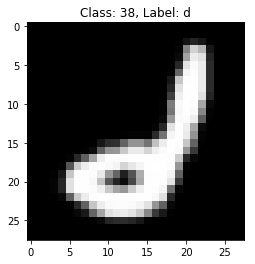

In [38]:
test_data = pd.read_csv(test_data_path, header=None)
show_img(test_data, 123)

In [0]:
X_test, y_test = img_label_load(test_data_path)

In [0]:
def run_prediction(idx):
    result = np.argmax(model.predict(X_test[idx:idx+1]))
    print('Prediction: ', result, ', Char: ', class_mapping[result])
    print('Label: ', test_data.values[idx,0])
    show_img(test_data, idx)

Prediction:  30 , Char:  U
Label:  21
Prediction:  41 , Char:  g
Label:  16
Prediction:  41 , Char:  g
Label:  16
Prediction:  35 , Char:  Z
Label:  40
Prediction:  23 , Char:  N
Label:  8
Prediction:  41 , Char:  g
Label:  37
Prediction:  41 , Char:  g
Label:  16
Prediction:  41 , Char:  g
Label:  16
Prediction:  41 , Char:  g
Label:  26


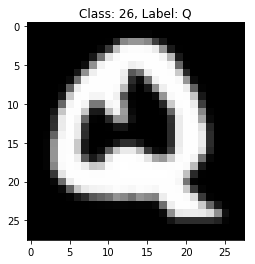

In [43]:
import random

for _ in range(1,10):
    idx = random.randint(0, 47-1)
    run_prediction(idx)

38

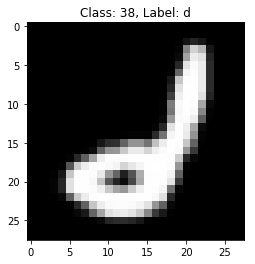

In [44]:
show_img(test_data, 123)
np.argmax(y_test[123])

As the new model is working fine, we export it in form of  .pb file to be used in our Android Project

In [0]:
MODEL_NAME = "emnist_convnet-keras"

In [50]:
export_model(tf.train.Saver(), model_new, ["conv2d_10_input"], "dense_8/Softmax")

INFO:tensorflow:Restoring parameters from out/emnist_convnet-keras.chkp
INFO:tensorflow:Froze 10 variables.
Converted 10 variables to const ops.
Graph saved!
